In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from collections import Counter
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import gensim
import os
os.listdir("../input/ykc-cup-2nd/")

['wiki-news-300d-1M.vec', 'train.csv', 'test.csv', 'sample_submission.csv']

## read data 

In [2]:
train = pd.read_csv("../input/ykc-cup-2nd/train.csv")
test = pd.read_csv("../input/ykc-cup-2nd/test.csv")
sub = pd.read_csv("../input/ykc-cup-2nd/sample_submission.csv")
train.shape, test.shape, sub.shape

((24842, 6), (24843, 5), (24843, 2))

In [3]:
train.head()

,product_id,product_name,order_rate,order_dow_mode,order_hour_of_day_mode,department_id
0,0,All-Seasons Salt,2.779494e-06,0,11,12
1,1,Smart Ones Classic Favorites Mini Rigatoni Wit...,1.037875e-05,0,16,0
2,2,Green Chile Anytime Sauce,4.731054e-07,0,11,12
3,3,Dry Nose Oil,2.365527e-07,6,10,10
4,4,Pure Coconut Water With Orange,9.166416e-07,3,14,6


In [4]:
test.head()

,product_id,product_name,order_rate,order_dow_mode,order_hour_of_day_mode
0,24842,Chocolate Sandwich Cookies,0.000057,1,10
1,24843,Robust Golden Unsweetened Oolong Tea,0.000008,1,11
2,24844,Sparkling Orange Juice & Prickly Pear Beverage,0.000080,1,11
3,24845,Peach Mango Juice,0.000003,1,12
4,24846,Chocolate Fudge Layer Cake,0.000008,6,18


In [5]:
sub.head()

,product_id,department_id
0,24842,0
1,24843,0
2,24844,0
3,24845,0
4,24846,0


In [6]:
## trainとtestをくっつけて一括で特徴量作成をする
df = pd.concat([train, test])
df = df.reset_index(drop=True)
df.shape

(49685, 6)

## EDA

In [7]:
train[train["department_id"] == 3].head()
## 野菜とか果物？

,product_id,product_name,order_rate,order_dow_mode,order_hour_of_day_mode,department_id
25,25,European Cucumber,5.629362e-04,0,11,3
33,33,European Style Spring Mix,7.303564e-06,1,14,3
42,42,Yogurt Fruit Dip Sliced Apples,1.123625e-06,5,14,3
58,58,Cauliflower Florettes,4.435363e-07,0,11,3
70,70,Organic Lemons,7.687962e-07,3,12,3


In [8]:
train[train["department_id"] == 12].head()
## 調味料？

,product_id,product_name,order_rate,order_dow_mode,order_hour_of_day_mode,department_id
0,0,All-Seasons Salt,2.779494e-06,0,11,12
2,2,Green Chile Anytime Sauce,4.731054e-07,0,11,12
47,47,Sprinklez Confetti Fun Organic Toppings,6.327784e-06,6,10,12
51,51,Mild Salsa Divino,1.833283e-06,6,17,12
54,54,Hot Tomatillo Salsa,1.892421e-06,1,10,12


In [9]:
train[train["department_id"] == 16].head()
##洗濯用具とか

,product_id,product_name,order_rate,order_dow_mode,order_hour_of_day_mode,department_id
8,8,Fresh Scent Dishwasher Cleaner,5.322435e-07,4,18,16
53,53,"Fabric Softener, Geranium Scent",2.749925e-06,0,17,16
64,64,Stain Release Boost In-Wash Stain Remover Pacs,1.123625e-06,0,13,16
76,76,Fabric Refresher Meadows & Rain Air Freshener ...,1.389747e-06,0,12,16
96,96,Free & Clear Natural Laundry Detergent For Sen...,1.510389e-04,0,14,16


## feature engineering

In [10]:
df["product_name"] = df["product_name"].apply(lambda words : words.lower().replace(",", "").replace("&", "").split(" "))
df.head()

,product_id,product_name,order_rate,order_dow_mode,order_hour_of_day_mode,department_id
0,0,"[all-seasons, salt]",2.779494e-06,0,11,12.0
1,1,"[smart, ones, classic, favorites, mini, rigato...",1.037875e-05,0,16,0.0
2,2,"[green, chile, anytime, sauce]",4.731054e-07,0,11,12.0
3,3,"[dry, nose, oil]",2.365527e-07,6,10,10.0
4,4,"[pure, coconut, water, with, orange]",9.166416e-07,3,14,6.0


In [11]:
## 訓練済みの単語ベクトルを読み込んで，product_nameに含まれる単語をベクトルに変換して平均を取ることで，各product_idに対して特徴量ベクトルを作成する

## gensimで.vecから読み込むときに時間がかかるので，他のnotebookでpickleで保存したものを使用している
model = pd.read_pickle("../input/ykc-cup-2nd-save-fasttext/fasttext_gensim_model.pkl") 

## gensimでvecから読み込む場合（５分ぐらいかかる）
# model = gensim.models.KeyedVectors.load_word2vec_format('../input/ykc-2nd/wiki-news-300d-1M.vec/wiki-news-300d-1M.vec')

from collections import defaultdict
unused_words = defaultdict(int)
def to_vec(x, model):
    v = np.zeros(model.vector_size)
    for w in x:
        try:
            v += model[w] ## 単語が訓練済みモデルのvocabにあったら
        except:
            unused_words[w] += 1 ## ベクトルが存在しなかった単語をメモ
    v = v / (np.sqrt(np.sum(v ** 2)) + 1e-16) ## 長さを1に正規化
    return v    
vecs = df["product_name"].apply(lambda x : to_vec(x, model))
vecs = np.vstack(vecs)
fasttext_pretrain_cols = [f"fasttext_pretrain_vec{k}" for k in range(vecs.shape[1])]
vec_df = pd.DataFrame(vecs, columns=fasttext_pretrain_cols)
df = pd.concat([df, vec_df], axis = 1)
df.head()

,product_id,product_name,order_rate,order_dow_mode,order_hour_of_day_mode,department_id,fasttext_pretrain_vec0,fasttext_pretrain_vec1,fasttext_pretrain_vec2,fasttext_pretrain_vec3,...,fasttext_pretrain_vec290,fasttext_pretrain_vec291,fasttext_pretrain_vec292,fasttext_pretrain_vec293,fasttext_pretrain_vec294,fasttext_pretrain_vec295,fasttext_pretrain_vec296,fasttext_pretrain_vec297,fasttext_pretrain_vec298,fasttext_pretrain_vec299
0,0,"[all-seasons, salt]",2.779494e-06,0,11,12.0,-0.016038,-0.005413,-0.030873,0.040061,...,-0.057035,0.031508,0.005112,0.000568,-0.008253,0.040396,0.056868,0.071870,-0.009923,-0.000702
1,1,"[smart, ones, classic, favorites, mini, rigato...",1.037875e-05,0,16,0.0,-0.044100,-0.020597,-0.012222,0.060443,...,0.002409,-0.017017,-0.006144,0.038623,0.002476,-0.041209,0.012066,0.092758,0.062074,-0.079980
2,2,"[green, chile, anytime, sauce]",4.731054e-07,0,11,12.0,-0.018035,0.048657,0.011118,0.068726,...,0.077602,-0.022785,-0.004824,0.016669,-0.038935,-0.043521,0.035625,0.018629,0.042928,0.042913
3,3,"[dry, nose, oil]",2.365527e-07,6,10,10.0,-0.051420,-0.023629,-0.048042,-0.030788,...,-0.048886,-0.037484,0.001347,-0.010236,0.002433,0.105475,-0.012166,0.042813,0.053351,0.032356
4,4,"[pure, coconut, water, with, orange]",9.166416e-07,3,14,6.0,0.027223,-0.002388,-0.010507,0.014792,...,-0.027605,0.020973,0.026813,-0.031821,-0.015133,0.045930,0.020277,0.069537,0.072880,0.021491


In [12]:
sorted(unused_words.items(), key=lambda x: x[1], reverse = True)[:100]

[('', 5659),
 ('100%', 693),
 ('2%', 116),
 ("women's", 64),
 ('1%', 58),
 ('softgels', 56),
 ("children's", 56),
 ("men's", 55),
 ('k-cups', 41),
 ('0%', 41),
 ('70%', 40),
 ('febreze', 39),
 ('grahams', 38),
 ('k-cup', 37),
 ('w/', 36),
 ('almondmilk', 33),
 ("s'mores", 31),
 ('steamfresh', 30),
 ('multi-surface', 30),
 ('hommus', 29),
 ('pro-v', 28),
 ("lil'", 27),
 ('volumizing', 27),
 ('rigate', 26),
 ('anticavity', 26),
 ('in-wash', 25),
 ('keurig', 25),
 ('72%', 25),
 ("o's", 25),
 ('eggo', 24),
 ('pantiliners', 23),
 ('havarti', 22),
 ('non-drowsy', 22),
 ("n'", 21),
 ('lunchables', 21),
 ('antiperspirant/deodorant', 21),
 ('velveeta', 20),
 ('reliever/fever', 19),
 ('85%', 19),
 ('pop-tarts', 19),
 ('organix', 19),
 ("reese's", 19),
 ("chef's", 19),
 ('8\\"', 19),
 ('99%', 18),
 ('50%', 18),
 ('muenster', 18),
 ('pure-castile', 17),
 ('18-in-1', 17),
 ('98%', 17),
 ('nutri-grain', 17),
 ('smartblend', 17),
 ('snickerdoodle', 17),
 ('4%', 16),
 ('phyto-caps', 16),
 ('9\\"', 16)

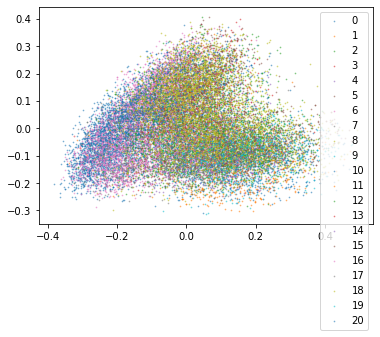

In [13]:
## fasttextから得られたベクトルを2次元に落として散布図を書いてみる
pc = PCA(2).fit_transform(df[fasttext_pretrain_cols])
for department_id in range(21):
    idx = np.where(df["department_id"] == department_id)[0]
    plt.scatter(pc[idx,0], pc[idx,1], label = department_id, s = 0.5, alpha = 0.5)
plt.legend()

## train

In [14]:
features = fasttext_pretrain_cols + ["order_rate", "order_dow_mode", "order_hour_of_day_mode"] ## 予測に使用する特徴量の名前
target = "department_id" ## 予測対象
n_split = 5 ## cross validationのfold数

In [15]:
## trainとtestを分離
train = df[~df[target].isna()]
test = df[df[target].isna()]

In [16]:
## cross validation
preds_test = []
scores = []
kfold = KFold(n_splits=n_split, shuffle = True, random_state=42)
for i_fold, (train_idx, valid_idx) in enumerate(kfold.split(train)):
    print(f"--------fold {i_fold}-------")
    
    ## train data
    x_tr = train.loc[train_idx, features]
    y_tr = train.loc[train_idx, target]

    ## valid data
    x_va = train.loc[valid_idx, features]
    y_va = train.loc[valid_idx, target]

    param={'lambda_l1': 0.05757233864212971,
           'lambda_l2': 4.644528267572721e-08,
           'num_leaves': 185,
           'feature_fraction': 0.8432452014952949,
           'bagging_fraction': 0.7795604743183974,
           'bagging_freq': 6,
           'min_child_samples': 61}
    ## train LGBM model
    model = LGBMClassifier(**param)
    model.fit(x_tr, y_tr, )
    
    ## predict on valid
    pred_val = model.predict_proba(x_va)
    
    ## evaluate
    score = {
        "logloss"  : log_loss(y_va, pred_val),
        "f1_micro" : f1_score(y_va, np.argmax(pred_val, axis = 1), average = "micro")}
    print(score)
    scores.append(score)
    
    ## predict on test
    pred_test = model.predict_proba(test[features])
    preds_test.append(pred_test)

--------fold 0-------
{'logloss': 0.9129269538285438, 'f1_micro': 0.7524652847655464}
--------fold 1-------
{'logloss': 0.8982579750713701, 'f1_micro': 0.7607164419400282}
--------fold 2-------
{'logloss': 0.9460103027490266, 'f1_micro': 0.750805152979066}
--------fold 3-------
{'logloss': 0.928471207856856, 'f1_micro': 0.7471819645732689}
--------fold 4-------
{'logloss': 0.920052150458103, 'f1_micro': 0.7536231884057971}


In [17]:
score_df = pd.DataFrame(scores)
score_df

,logloss,f1_micro
0,0.912927,0.752465
1,0.898258,0.760716
2,0.946010,0.750805
3,0.928471,0.747182
4,0.920052,0.753623


In [18]:
score_df.mean()

logloss     0.921144
f1_micro    0.752958
dtype: float64

## submission

In [19]:
## cvの各foldで計算した予測値の平均を最終的な予測値に
pred_test_final = np.array(preds_test).mean(axis = 0)
pred_test_final = np.argmax(pred_test_final, axis = 1)

In [20]:
sub["department_id"] = pred_test_final
sub.to_csv("submission.csv", index = False)
sub.head()

,product_id,department_id
0,24842,18
1,24843,6
2,24844,6
3,24845,6
4,24846,12
